In [9]:
import os
import cv2
import csv
import json
import math
import random
import decord
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageSequence
from io import BytesIO
from IPython.display import Video
from IPython.display import display, Image as IPyImage
import torchvision.transforms as T

import sys
from media_pipe.mp_utils import LMKExtractor
from media_pipe.draw_util import FaceMeshVisualizer
from media_pipe.pose_util import project_points_with_trans, matrix_to_euler_and_translation, euler_and_translation_to_matrix


ROOT = 'root_path'

def show_img(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img)
    plt.show()
    
def read_video(video_path):
    vr = decord.VideoReader(video_path)
    frames = vr.get_batch(list(range(len(vr))))
    return frames
    
def display_gif(image_array, duration=100):
    # Convert NumPy array to list of PIL images
    images = [Image.fromarray(frame) for frame in image_array]

    # Save images as GIF and read into memory buffer
    buffer = BytesIO()
    images[0].save(buffer, format='GIF', save_all=True, append_images=images[1:], duration=duration, loop=0)

    # Display GIF in Jupyter Notebook
    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

In [4]:
lmk_extractor = LMKExtractor()
vis = FaceMeshVisualizer(forehead_edge=False)

d:\GitHub\FollowYourEmoji\followyouremoji_env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


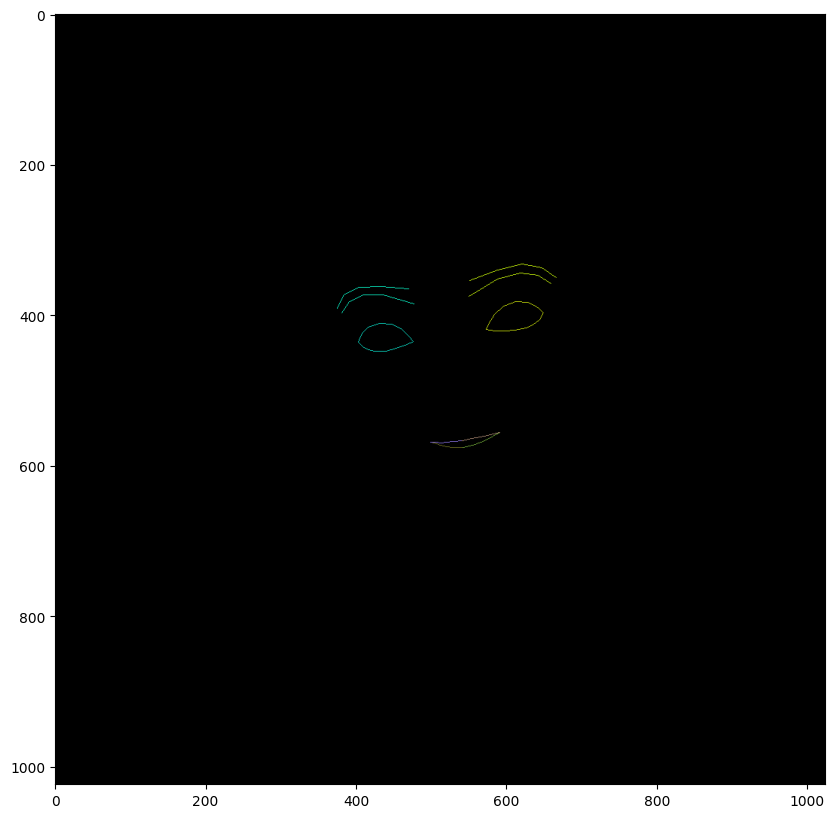

In [11]:
# Test if landmarks can be detected

# Set the path to the reference image
ref_image_path = f'2024-09-10_09-11-07_6467.png'

# Open the image and convert it to RGB
ref_image_pil = Image.open(ref_image_path).convert("RGB")

# Convert the PIL image to a numpy array and change color space from RGB to BGR
ref_image_np = cv2.cvtColor(np.array(ref_image_pil), cv2.COLOR_RGB2BGR)

# Uncomment the following line if you want to display the image
# show_img(ref_image_pil)

# Extract landmarks from the image
face_result = lmk_extractor(ref_image_np)

# Ensure that a face was detected in the image
assert face_result is not None, "Cannot detect a face in the reference image."

# Add width and height information to the face_result dictionary
face_result['width'] = ref_image_np.shape[1]
face_result['height'] = ref_image_np.shape[0]

# Save the face landmark results
save_path = ref_image_path.replace('.png', '_mppose.npy')
np.save(save_path, face_result)

# Extract landmarks and convert to float32
lmks = face_result['lmks'].astype(np.float32)

# Draw landmarks on the image
ref_pose = vis.draw_landmarks((ref_image_np.shape[1], ref_image_np.shape[0]), lmks, normed=True)

# Display the image with landmarks
show_img(ref_pose)

## Template Extraction

In [13]:
from tqdm import tqdm

# Set the path to the video file
video_path = f'20240911_074529.mp4'

# Read the video file
frames = imageio.get_reader(video_path)

face_results = []
motions = []

# Process each frame in the video
for frame in tqdm(frames):
    # Convert frame from RGB to BGR color space
    frame_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
    
    # Extract facial landmarks from the frame
    face_result = lmk_extractor(frame_bgr)
    assert face_result is not None, "Cannot detect a face in the frame."
    
    # Add width and height information to the face_result
    face_result['width'] = frame_bgr.shape[1]
    face_result['height'] = frame_bgr.shape[0]
    
    # Store the face result
    face_results.append(face_result)
    
    # Extract landmarks and convert to float32
    lmks = face_result['lmks'].astype(np.float32)
    
    # Draw landmarks on the frame
    motion = vis.draw_landmarks((frame_bgr.shape[1], frame_bgr.shape[0]), lmks, normed=True)
    motions.append(motion)

# Print the number of processed frames
print(len(motions))

# Save the landmark visualizations as a GIF
save_path = video_path.replace('.mp4', '_mppose.gif')
imageio.mimsave(save_path, motions, 'GIF', duration=0.2, loop=0)
print(save_path, 'done')

# Save the facial landmark results
save_path = video_path.replace('.mp4', '_mppose.npy')
np.save(save_path, face_results)
print(save_path, 'done')

  0%|          | 0/9223372036854775807 [00:00<?, ?it/s]d:\GitHub\FollowYourEmoji\followyouremoji_env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
  0%|          | 415/9223372036854775807 [00:08<49810068401992:45:52, 51.44it/s]


415
20240911_074529_mppose.gif done
20240911_074529_mppose.npy done


## Align